# MSPAC Fitting Procedure

> Joseph P. Vantassel, The University of Texas at Austin

Simple example to demonstrate tMSPAC data fitting procedure.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import swprocess

## Create Example Data Set
---

### Create Synthetic Dispersion Data

c:\users\joe\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()


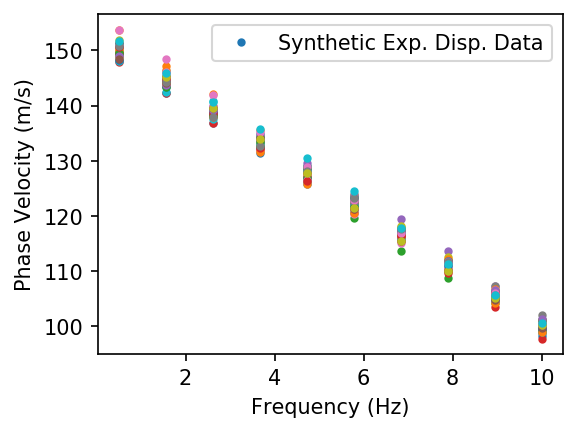

In [2]:
rng = np.random.default_rng(1824)

n = 10
vel_frq = np.linspace(0.5, 10, n)
vel_mean = np.linspace(150, 100, n)
vel_std = vel_mean * np.linspace(0.01, 0.01, n)

cov = np.ones((n, n))
rho = 2
std2 = vel_std*vel_std
rho2 = rho*rho
for row, f in enumerate(vel_frq):
    diff = f-vel_frq
    cov[row] = std2*np.exp(-0.5*diff*diff/rho2)

edd = rng.multivariate_normal(mean=vel_mean, cov=cov, size=(30), tol=1E-6)

fig, ax = plt.subplots(figsize=(4,3), dpi=150)

label = "Synthetic Exp. Disp. Data"
for _edd in edd:
    ax.plot(vel_frq, _edd, marker=".", linestyle="", label=label)
    label = ""

ax.legend(loc="upper right")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Phase Velocity (m/s)")
plt.show()

### Compute Implied SPAC Ratios

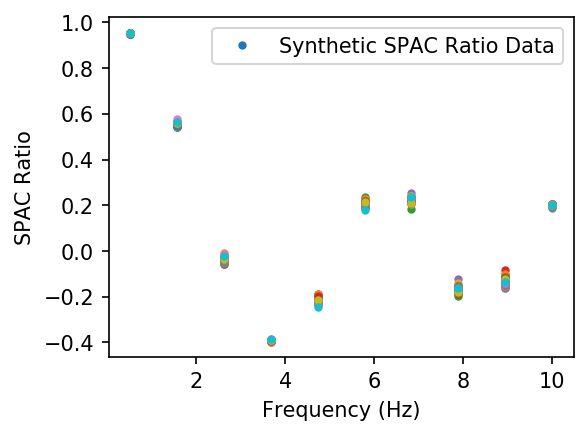

In [3]:
# Assume data came from the vertical component of a ring spanning 20 - 22 m.
meta = dict(component=0, dmin=20, dmax=22)
spac_ratio_fxn = swprocess.SpacCurve.theoretical_spac_ratio_function_general(**meta)
meta["ring"] = 0
meta["time"] = "0"
spaccurve = swprocess.SpacCurve(vel_frq, spac_ratio_fxn(vel_frq, edd[0]), **meta)
spaccurvesuite = swprocess.SpacCurveSuite(spaccurve)
for index, _edd in enumerate(edd[1:], 1):
    spaccurve = swprocess.SpacCurve(vel_frq, spac_ratio_fxn(vel_frq, edd[index]), **meta)
    spaccurvesuite.append(spaccurve)

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
label = "Synthetic SPAC Ratio Data"
for spaccurve in spaccurvesuite:
    ax.plot(spaccurve.frequencies, spaccurve.ratios, marker=".", linestyle="", label=label)
    label = ""
    
ax.legend(loc="upper right")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("SPAC Ratio")
plt.show()

## Transform Snythetic Spac Ratio Data back to the Phase Velocity Space
---

### Calculate SPAC Ratio Statistics

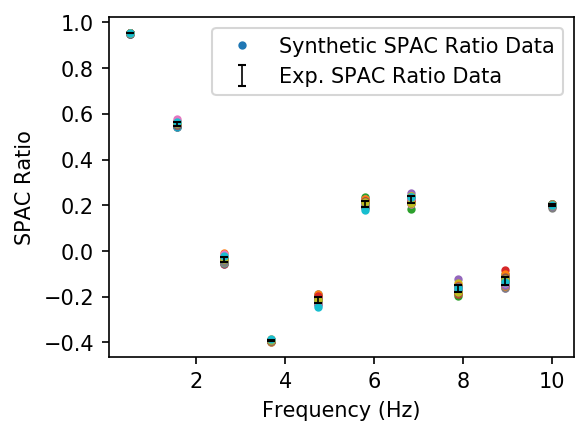

In [4]:
spac_frq, spac_mean, spac_std, spac_cov = spaccurvesuite._calc_spac_ratio_stats()

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
label = "Synthetic SPAC Ratio Data"
for spaccurve in spaccurvesuite:
    ax.plot(spaccurve.frequencies, spaccurve.ratios, marker=".", linestyle="", label=label)
    label = ""
    
ax.errorbar(spac_frq, spac_mean, yerr=spac_std, color="k", linestyle="", zorder=6, capsize=2, linewidth=0.8, label="Exp. SPAC Ratio Data")

ax.legend(loc="upper right")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("SPAC Ratio")
plt.show()

### Transform SPAC Ratio Statistics to Phase Velocity Statistics using Non-linear Least Squares

499


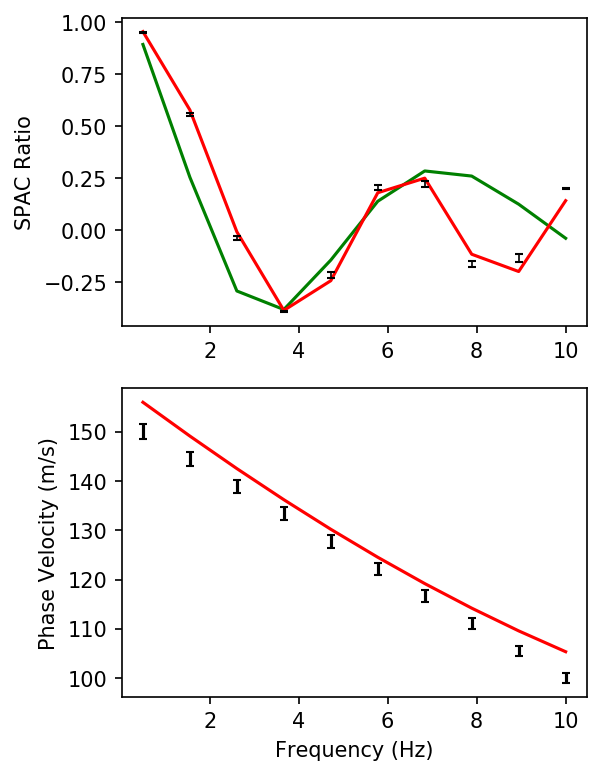

In [54]:
p0 = np.linspace(100, 150, n)
p0_std = 20

rec_vel_frq, rec_vel_mean, rec_vel_std, rec_vel_corr = spaccurvesuite._to_phase_stat(p0=p0, p0_std=p0_std, omega=300, iterations=500, tol=0.01)

fig, axs = plt.subplots(nrows=2, figsize=(4, 6), dpi=150)

ax = axs[0]
ax.errorbar(spac_frq, spac_mean, yerr=spac_std,
            color="k", linestyle="", zorder=6, capsize=2, linewidth=0.8, label="Exp. SPAC Ratio Data")

ax.plot(spaccurvesuite[0].frequencies, spac_ratio_fxn(spaccurvesuite[0].frequencies, p0),
        color="g")

ax.plot(rec_vel_frq, spac_ratio_fxn(rec_vel_frq, rec_vel_mean),
        color="r")

ax.set_ylabel("SPAC Ratio")

ax = axs[1]

ax.errorbar(vel_frq, vel_mean, yerr=vel_std,
            color="k", linestyle="", zorder=6, capsize=2, label="True Exp. Disp. Data")

ax.errorbar(rec_vel_frq, rec_vel_mean,
            color="r", linestyle="-", zorder=6, capsize=2, label="Recovered Exp. Disp. Data")

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Phase Velocity (m/s)")
plt.show()